# Loading libraries

In [1]:
import pickle
import os
from joblib import Parallel, delayed

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reading datasets

## Reviews dataset

In [2]:
# Specify the path to your Parquet file
reviews_file = '/Users/ShanShan/BT4301/MySQL/test/cleaned/results2/ucb/min20/book_reviews_with_sentiment_sample10k_segmented.parquet'

# Read the Parquet file into a pandas DataFrame
reviews_df = pd.read_parquet(reviews_file)

In [3]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188704 entries, 0 to 188703
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rating             188704 non-null  float64
 1   parent_asin        188704 non-null  object 
 2   user_id            188704 non-null  object 
 3   timestamp          188704 non-null  int64  
 4   verified_purchase  188704 non-null  bool   
 5   sentiment_score    188704 non-null  float64
 6   segment            188704 non-null  int64  
dtypes: bool(1), float64(2), int64(2), object(2)
memory usage: 8.8+ MB


In [4]:
reviews_df.shape

(188704, 7)

In [5]:
reviews_df.columns

Index(['rating', 'parent_asin', 'user_id', 'timestamp', 'verified_purchase',
       'sentiment_score', 'segment'],
      dtype='object')

In [6]:
# Display the first few rows
reviews_df.head()

,rating,parent_asin,user_id,timestamp,verified_purchase,sentiment_score,segment
0,5.0,B08ZL917NS,AEPT3SLK3KKRUCBVKDUZ5ZKWXOIA,1617723567652,True,0.355952,3
1,5.0,B084RVQ1JY,AEPT3SLK3KKRUCBVKDUZ5ZKWXOIA,1609346913702,True,0.118561,3
2,5.0,B07QXHWWMX,AEPT3SLK3KKRUCBVKDUZ5ZKWXOIA,1606275789621,True,0.146875,3
3,5.0,B0812BLBMM,AEPT3SLK3KKRUCBVKDUZ5ZKWXOIA,1606275036472,True,0.339216,3
4,5.0,B082RD9D1H,AEPT3SLK3KKRUCBVKDUZ5ZKWXOIA,1601056554310,True,0.236198,3


## Meta dataset

In [7]:
# Specify the path to your Parquet file
meta_parquet_file = '/Users/ShanShan/BT4301/MySQL/test/cleaned/results2/books_metadata.csv'

# Read the Parquet file into a pandas DataFrame
meta_df = pd.read_csv(meta_parquet_file)

In [8]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1591371 entries, 0 to 1591370
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   title             1591371 non-null  object 
 1   average_rating    1591371 non-null  float64
 2   rating_number     1591371 non-null  int64  
 3   price             1375812 non-null  object 
 4   parent_asin       1591371 non-null  object 
 5   author            1591060 non-null  object 
 6   genre             1591371 non-null  object 
 7   publisher         994493 non-null   object 
 8   publication_date  1532776 non-null  object 
 9   language          1533286 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 121.4+ MB


In [9]:
meta_df.shape

(1591371, 10)

In [10]:
meta_df.columns

Index(['title', 'average_rating', 'rating_number', 'price', 'parent_asin',
       'author', 'genre', 'publisher', 'publication_date', 'language'],
      dtype='object')

In [11]:
# Display the first few rows
meta_df.head()

,title,average_rating,rating_number,price,parent_asin,author,genre,publisher,publication_date,language
0,The Palace (Chateau Book 4),4.7,970,0.0,B08XPZPFY4,Penelope Sky,Romance,"Hartwick Publishing (May 25, 2021)","May 25, 2021",English
1,Microsoft PowerPoint 2016 2013 2010 2007 Tips ...,4.3,35,0.0,B07DH1LF1K,Amelia Griggs,Computers & Technology,NaN,"June 2, 2018",English
2,Ill Wind (Anna Pigeon Mysteries Book 3),4.4,1628,7.99,B0022Q8CTQ,Nevada Barr,"Mystery, Thriller & Suspense","Berkley; Reissue edition (March 29, 2009)","March 29, 2009",English
3,30 Healthy Easy Quick Lentil Recipes (Brad Arm...,3.8,47,0.0,B00BS56MLC,Brad Armstrong,"Health, Fitness & Dieting","Brad Armstrong (March 10, 2013)","March 10, 2013",English
4,The Road Home,4.5,475,10.44,B00155EZRS,Jim Harrison,Literature & Fiction,"Atlantic Monthly Press (December 1, 2007)","December 1, 2007",English


# Check for missing values

## Reviews dataset

In [12]:
# Check for missing values
reviews_df.isnull().sum()

rating               0
parent_asin          0
user_id              0
timestamp            0
verified_purchase    0
sentiment_score      0
segment              0
dtype: int64

## Meta dataset

In [13]:
# Check for missing values
meta_df.isnull().sum()

title                    0
average_rating           0
rating_number            0
price               215559
parent_asin              0
author                 311
genre                    0
publisher           596878
publication_date     58595
language             58085
dtype: int64

# MAB

In [14]:
class ReplaySimulator(object):
    def __init__(self, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1, random_seed=1):
        # Set random seed for reproducibility
        np.random.seed(random_seed)

        # Store simulation parameters and data
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name

        # Number of visits to replay/simulate
        self.n_visits = n_visits

        # Number of runs to average over
        self.n_iterations = n_iterations

         # Items under test
        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)

        # Visitors in the historical reward_history
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)

    def reset(self):
       # Initialize counters for item samples and rewards
        self.n_item_samples = np.zeros(self.n_items)
        self.n_item_rewards = np.zeros(self.n_items)

    def replay(self):
        # Precompute possible rewards for each visitor-item pair
        reward_dict = {}
        for _, row in self.reward_history.iterrows():
            visitor_id = row[self.visitor_col_name]
            item_id = row[self.item_col_name]
            reward = row[self.reward_col_name]
            reward_dict.setdefault(visitor_id, {})[item_id] = reward

        # Store simulation results
        results = []

        # Run the simulation for the specified number of iterations
        for iteration in tqdm(range(0, self.n_iterations)):
            # Reset counters for each iteration
            self.reset()
            total_rewards = 0
            fraction_relevant = np.zeros(self.n_visits)

            for visit in range(0, self.n_visits):
                found_match = False
                while not found_match:
                    # Randomly select a visitor
                    visitor_idx = np.random.randint(self.n_visitors)
                    visitor_id = self.visitors[visitor_idx]

                    # Select an item to offer the visitor
                    item_idx = self.select_item()
                    item_id = self.items[item_idx]

                    # Check if this interaction exists in the precomputed reward_dict
                    if visitor_id in reward_dict and item_id in reward_dict[visitor_id]:
                        reward_value = reward_dict[visitor_id][item_id]
                        found_match = True
                    else:
                        # No match found, reselect
                        continue

                # Record the result and update counters
                self.record_result(visit, item_idx, reward_value)

                # Record metrics
                total_rewards += reward_value
                fraction_relevant[visit] = total_rewards / (visit + 1)

                # Log the result of this step
                results.append({
                    'iteration': iteration,
                    'visit': visit,
                    'item_id': item_id,
                    'visitor_id': visitor_id,
                    'reward': reward_value,
                    'total_reward': total_rewards,
                    'fraction_relevant': total_rewards / (visit + 1)
                })

        return results

    def select_item(self):
        # This method selects an item randomly
        return np.random.randint(self.n_items)

    def record_result(self, visit, item_idx, reward):
        # This method records the result of an interaction and updates item statistics

        # Update the number of times the item has been sampled
        self.n_item_samples[item_idx] += 1

         # Update the fraction of time the item has resulted in a reward        
        alpha = 1. / self.n_item_samples[item_idx]
        self.n_item_rewards[item_idx] += alpha * (reward - self.n_item_rewards[item_idx])

In [15]:
class EpsilonGreedyReplayer(ReplaySimulator):
    '''
    A class to provide functionality for simulating the replayer method on an epsilon-Greedy bandit algorithm.
    '''

    def __init__(self, epsilon, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1):
        super(EpsilonGreedyReplayer, self).__init__(n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations)
    
        # Parameter to control exploration vs exploitation
        self.epsilon = epsilon

    def select_item(self):
        # Decide to explore or exploit
        if np.random.uniform() < self.epsilon:  # Explore
            item_id = super(EpsilonGreedyReplayer, self).select_item()
        else:  # Exploit
            item_id = np.argmax(self.n_item_rewards)

        return item_id

    def ensure_min_recommendations(self, results_df):
        """
        Ensures that each user has at least 20 recommended items.
        If a user has fewer than 20, randomly selects more items while avoiding duplicates.
        """
                    
        # Aggregate results for each user and item to find the total rewards
        aggregated_results = results_df.groupby(['visitor_id', 'item_id'])['reward'].sum().reset_index()

        # Rank recommendations per user
        aggregated_results['rank'] = aggregated_results.groupby('visitor_id')['reward'].rank(ascending=False, method='first')

        # Count recommendations per user efficiently
        recommendation_counts = aggregated_results.groupby('visitor_id')['item_id'].count()

        # Identify users with fewer than 20 recommendations
        users_needing_more = recommendation_counts[recommendation_counts < 20]
        if not users_needing_more.empty:
            # Generate additional recommendations
            num_missing_dict = 20 - users_needing_more
            additional_users = users_needing_more.index

            # Randomly pick more items for users needing more recommendations
            additional_items = np.random.choice(self.items, num_missing_dict.sum())

            # Create the additional recommendations DataFrame
            additional_df = pd.DataFrame({
                'visitor_id': np.repeat(additional_users, num_missing_dict.values),
                'item_id': additional_items,
                'reward': 0,
                'rank': np.nan
            })

            # Concatenate additional recommendations to the aggregated results
            aggregated_results = pd.concat([aggregated_results, additional_df], ignore_index=True)

        # Rename visitor_id to user_id and item_id to parent_asin
        aggregated_results.rename(columns={'visitor_id': 'user_id', 'item_id': 'parent_asin'}, inplace=True)

        # Return the results grouped by user_id
        return aggregated_results

    def recommend_books_for_user(self, user_id, top_k=20):
            # Recommend top-K items globally by reward estimates
            item_scores = self.n_item_rewards
            top_indices = np.argsort(-item_scores)[:top_k]
            return self.items[top_indices]

        
    def get_model_state(self):
        return {
            'items': self.items,
            'n_item_samples': self.n_item_samples,
            'n_item_rewards': self.n_item_rewards
        }

    def load_model_state(self, state):
        self.items = state['items']
        self.n_items = len(self.items)
        self.n_item_samples = state['n_item_samples']
        self.n_item_rewards = state['n_item_rewards']


    def replay(self):
        results = super().replay()  # Run the original replay logic

        # Convert results into a DataFrame for easy aggregation
        results_df = pd.DataFrame(results)

        # Ensure each user gets at least 20 recommendations
        results_df = self.ensure_min_recommendations(results_df)

        return results_df

## Merging datasets

In [16]:
merged_df = reviews_df.merge(meta_df, on='parent_asin', how='inner')

In [17]:
# Retrieve the required columns and create a new dataframe
mab_df = merged_df[['user_id', 'parent_asin', 'price', 'title', 'segment']].copy()

In [18]:
mab_df.shape

(188704, 5)

In [19]:
unique_user_count = mab_df['user_id'].nunique()
print(f"Number of unique user_ids: {unique_user_count}")

Number of unique user_ids: 10000


## Setting parameters

In [20]:
# Ensure 'price' is numeric
mab_df['price'] = pd.to_numeric(mab_df['price'], errors='coerce')

# Create a new column 'spent' where price > 0 is considered spent
mab_df['spent'] = mab_df['price'] > 0

In [21]:
# Columns for the simulator
item_col_name = 'parent_asin'
visitor_col_name = 'user_id'
reward_col_name = 'spent'

# Parameters for the simulation
n_visits = 200000
n_iterations = 5
n_test_visits = 1000

epsilon = 0.05

## Running MAB for each segment

In [22]:
# Function to run MAB for a given segment
def run_mab_for_segment(segment, segment_df, n_visits, n_iterations):
    print(f"Running MAB for segment: {segment}")
    
    reward_history = segment_df[['user_id', 'parent_asin', 'spent']]
    
    replayer = EpsilonGreedyReplayer(
        epsilon,
        n_visits,
        reward_history,
        item_col_name,
        visitor_col_name,
        reward_col_name,
        n_iterations=n_iterations
    )
    
    recommended_books_df = replayer.replay()
    model_state = replayer.get_model_state()

    return segment, recommended_books_df, model_state


In [23]:
# Get unique segments
unique_segments = mab_df['segment'].unique()

num_cores = min(4, len(unique_segments))

# Run in parallel
segment_results_raw = Parallel(n_jobs=num_cores)(
    delayed(run_mab_for_segment)(segment, mab_df[mab_df['segment'] == segment], n_visits, n_iterations)
    for segment in unique_segments
)

# Extract results properly
segment_results_dict = {segment: recommended_books_df for segment, recommended_books_df, _ in segment_results_raw}
segment_model_states = {segment: model_state for segment, _, model_state in segment_results_raw}


Running MAB for segment: 3
Running MAB for segment: 2
Running MAB for segment: 1
Running MAB for segment: 0


100%|██████████| 5/5 [28:21:40<00:00, 20420.11s/it]  


In [24]:
for segment, df in segment_results_dict.items():
    print(f"Segment: {segment}, Shape: {df.shape}")

Segment: 3, Shape: (43620, 4)
Segment: 2, Shape: (55624, 4)
Segment: 0, Shape: (82799, 4)
Segment: 1, Shape: (18594, 4)


In [25]:
segment_results_df = pd.concat(segment_results_dict.values(), keys=segment_results_dict.keys(), names=['segment'])

In [26]:
unique_users_per_segment = segment_results_df.groupby('segment')['user_id'].nunique()
print(unique_users_per_segment)

segment
0    4136
1     830
2    2758
3    2181
Name: user_id, dtype: int64


In [30]:
# 3: 41933, 2254
# 2: 50392, 2760
# 0: 81907, 4156
# 1: 14472, 830

## Saving MAB model

In [27]:
for segment, df in segment_results_dict.items():
    filename = f'segment_{segment}.csv'
    df.to_csv(filename, index=False)  # Save each segment as a CSV
    globals()[f"df_{segment}"] = df  # Create separate DataFrame variables dynamically
    print(f"Saved CSV for segment '{segment}' as '{filename}'")

Saved CSV for segment '3' as 'segment_3.csv'
Saved CSV for segment '2' as 'segment_2.csv'
Saved CSV for segment '0' as 'segment_0.csv'
Saved CSV for segment '1' as 'segment_1.csv'


In [28]:
# Save each model state directly in current directory
for segment, model_state in segment_model_states.items():
    filename = f"model_state_segment_{segment}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(model_state, f)

    print(f"Saved model state for segment {segment} to {filename}")

Saved model state for segment 3 to model_state_segment_3.pkl
Saved model state for segment 2 to model_state_segment_2.pkl
Saved model state for segment 0 to model_state_segment_0.pkl
Saved model state for segment 1 to model_state_segment_1.pkl


## Recommending books using saved MAB model

In [29]:
with open("model_state_segment_1.pkl", 'rb') as f:
    model_state = pickle.load(f)

In [30]:
# Example for reloading a model and using it
replayer = EpsilonGreedyReplayer(
    epsilon=0.05,
    n_visits=0,
    reward_history=mab_df[['user_id', 'parent_asin', 'spent']],
    item_col_name='parent_asin',
    visitor_col_name='user_id',
    reward_col_name='spent',
    n_iterations=1
)

In [31]:
replayer.load_model_state(model_state)

In [32]:
# Recommend books for a user (using global top items)
recommended_books = replayer.recommend_books_for_user('AE2E5BEZV7IBVRCVNXKTZN2TYT5Q')

In [33]:
print(recommended_books)

['B07NDJ3LMW' 'B01J24W8AO' 'B079Q4CDDL' 'B00KQ2G7GS' 'B07197QM16'
 'B00L0M24CO' 'B073QZ26D4' 'B07BPV28CC' 'B0030P1WSG' 'B092T8VJJP'
 'B00HK3EWAE' 'B08518VQK1' 'B00A92V3XC' 'B07CHMFQ3J' 'B088QL4QSF'
 'B00VHLQQ8Q' 'B001BC8KBM' 'B000FC1IRM' 'B00EXTVTOA' 'B00699SCHE']


In [34]:
segment_results_df

user_id parent_asin  reward  rank
segment                                                              
3       0      AE22FPJQ6YSFA25LCQHUA4QLMNBA  B00MNSYUCQ       0   2.0
        1      AE22FPJQ6YSFA25LCQHUA4QLMNBA  B07R7DXCY3       1   1.0
        2      AE22TLKCCSIELIX5STGEEO32PBJQ  B07B611KQK       0   1.0
        3      AE22YNFWCWI4ENWO5I4OKG25WT4Q  B0897WXCTN       0   1.0
        4      AE22YNFWCWI4ENWO5I4OKG25WT4Q  B097DLGRQ8       0   2.0
...                                     ...         ...     ...   ...
1       18589  AHZQII6BOGL7QXXVSPPHX3JS346Q  B00957T4ZQ       0   NaN
        18590  AHZQII6BOGL7QXXVSPPHX3JS346Q  B097KN3NZW       0   NaN
        18591  AHZQII6BOGL7QXXVSPPHX3JS346Q  B00OEXM79Q       0   NaN
        18592  AHZQII6BOGL7QXXVSPPHX3JS346Q  B08HXKDJCN       0   NaN
        18593  AHZQII6BOGL7QXXVSPPHX3JS346Q  B06XC534FK       0   NaN

[200637 rows x 4 columns]

# Evaluation

In [35]:
# Function to evaluate MAB performance for a segment
def evaluate_mab(results_df, optimal_reward=1):
    rewards = results_df['reward'].values

    cumulative_rewards = np.cumsum(rewards)
    avg_rewards = cumulative_rewards / np.arange(1, len(rewards) + 1)
    cumulative_regret = np.cumsum(optimal_reward - rewards)
    optimal_actions = (rewards == optimal_reward).astype(int)
    optimal_action_percentage = np.cumsum(optimal_actions) / np.arange(1, len(optimal_actions) + 1)

    metrics = {
        "Cumulative Rewards": cumulative_rewards,
        "Average Reward Over Time": avg_rewards,
        "Cumulative Regret": cumulative_regret,
        "Optimal Action Percentage": optimal_action_percentage
    }

    return metrics

In [36]:
# Function to evaluate and plot results for each segment
def evaluate_mab_by_segment(df, optimal_reward=1):
    segments = df.index.get_level_values('segment').unique()

    for segment in segments:
        print(f"Evaluating Segment {segment}...")
        segment_df = df.xs(segment, level='segment')
        if len(segment_df) == 0:
            print(f"Segment {segment} has no data.\n")
            continue
        
        metrics = evaluate_mab(segment_df, optimal_reward=optimal_reward)

        # Plotting
        fig, ax = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle(f"Segment {segment} - MAB Performance", fontsize=16)

        ax[0, 0].plot(metrics["Cumulative Rewards"], label="Cumulative Reward", color='blue')
        ax[0, 0].set_title("Cumulative Reward Over Time")
        ax[0, 0].set_xlabel("Visits")
        ax[0, 0].set_ylabel("Cumulative Reward")

        ax[0, 1].plot(metrics["Average Reward Over Time"], label="Average Reward", color='green')
        ax[0, 1].set_title("Average Reward Over Time")
        ax[0, 1].set_xlabel("Visits")
        ax[0, 1].set_ylabel("Average Reward")

        ax[1, 0].plot(metrics["Cumulative Regret"], label="Cumulative Regret", color='red')
        ax[1, 0].set_title("Cumulative Regret Over Time")
        ax[1, 0].set_xlabel("Visits")
        ax[1, 0].set_ylabel("Cumulative Regret")

        ax[1, 1].plot(metrics["Optimal Action Percentage"], label="Optimal Actions", color='purple')
        ax[1, 1].set_title("Optimal Action Percentage Over Time")
        ax[1, 1].set_xlabel("Visits")
        ax[1, 1].set_ylabel("Percentage")

        for axes in ax.flat:
            axes.legend()

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


Evaluating Segment 3...


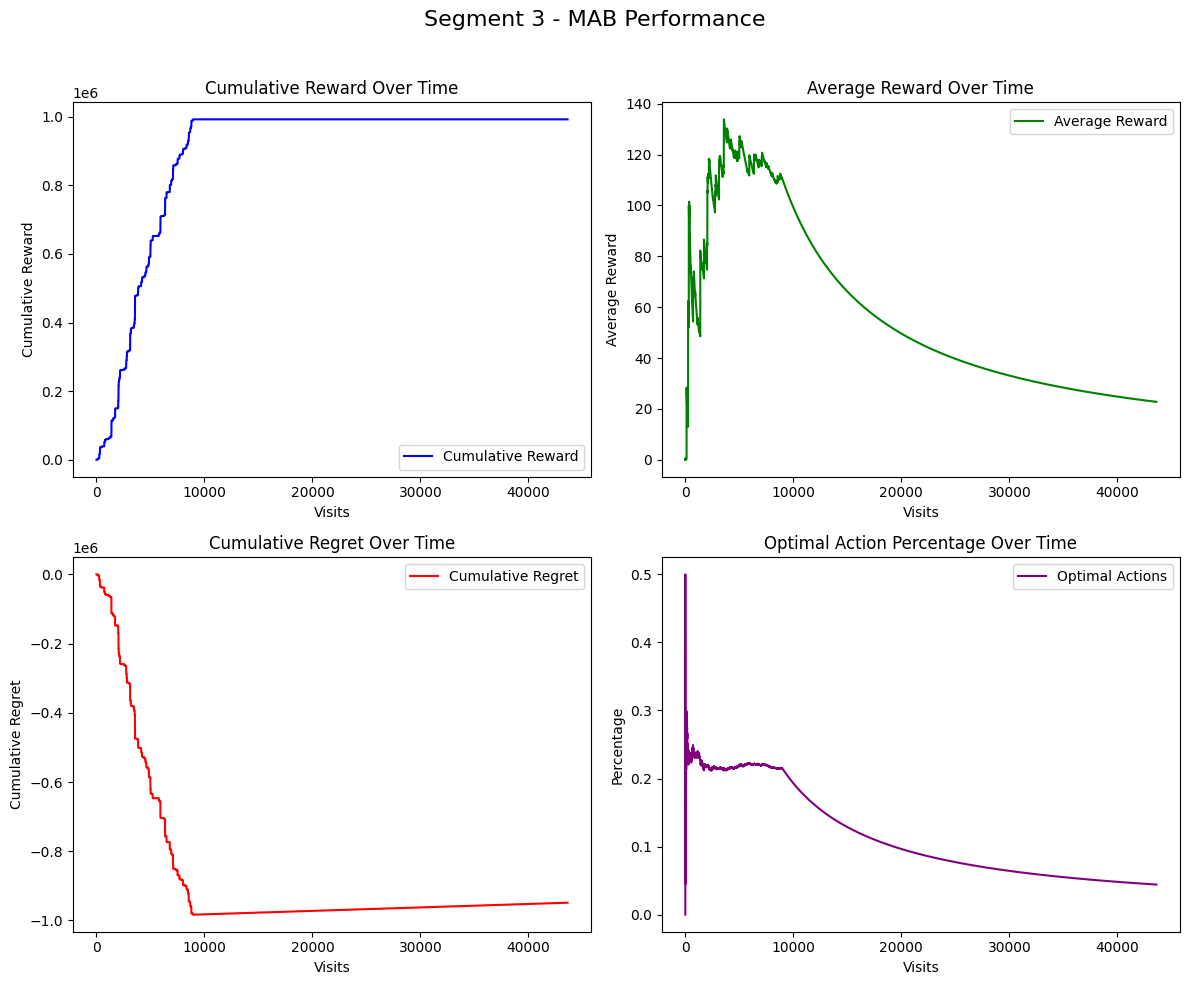

Evaluating Segment 2...


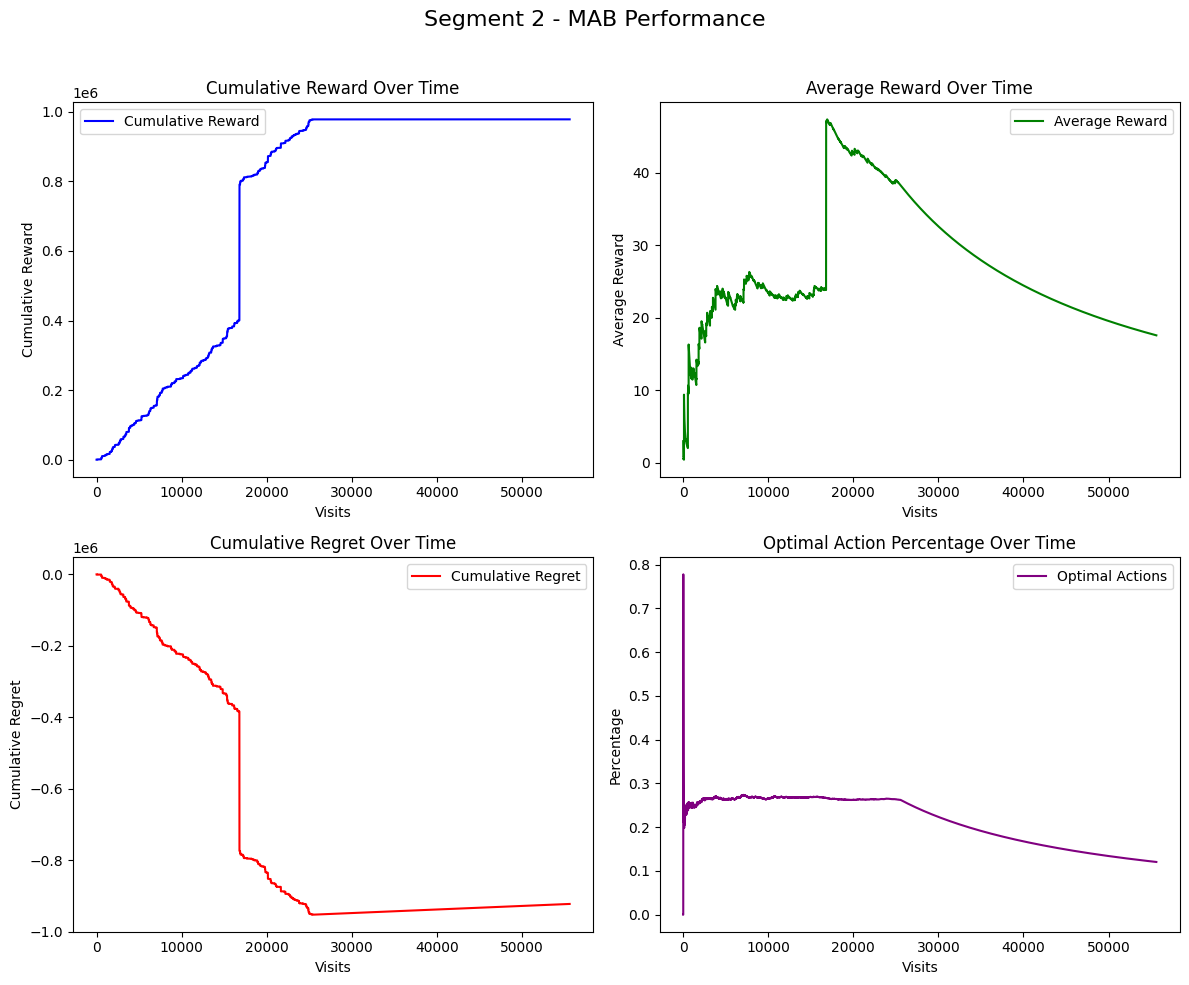

Evaluating Segment 0...


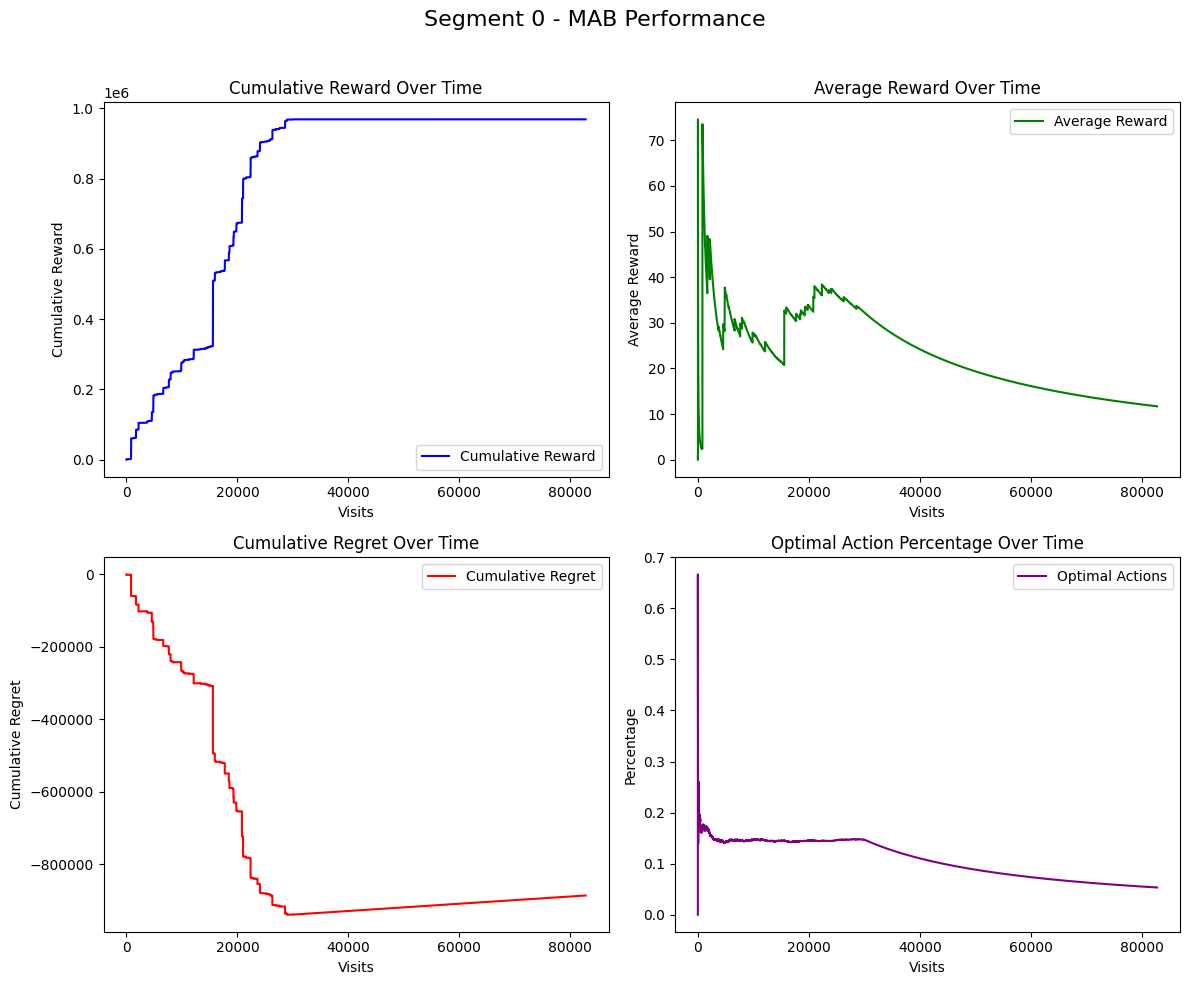

Evaluating Segment 1...


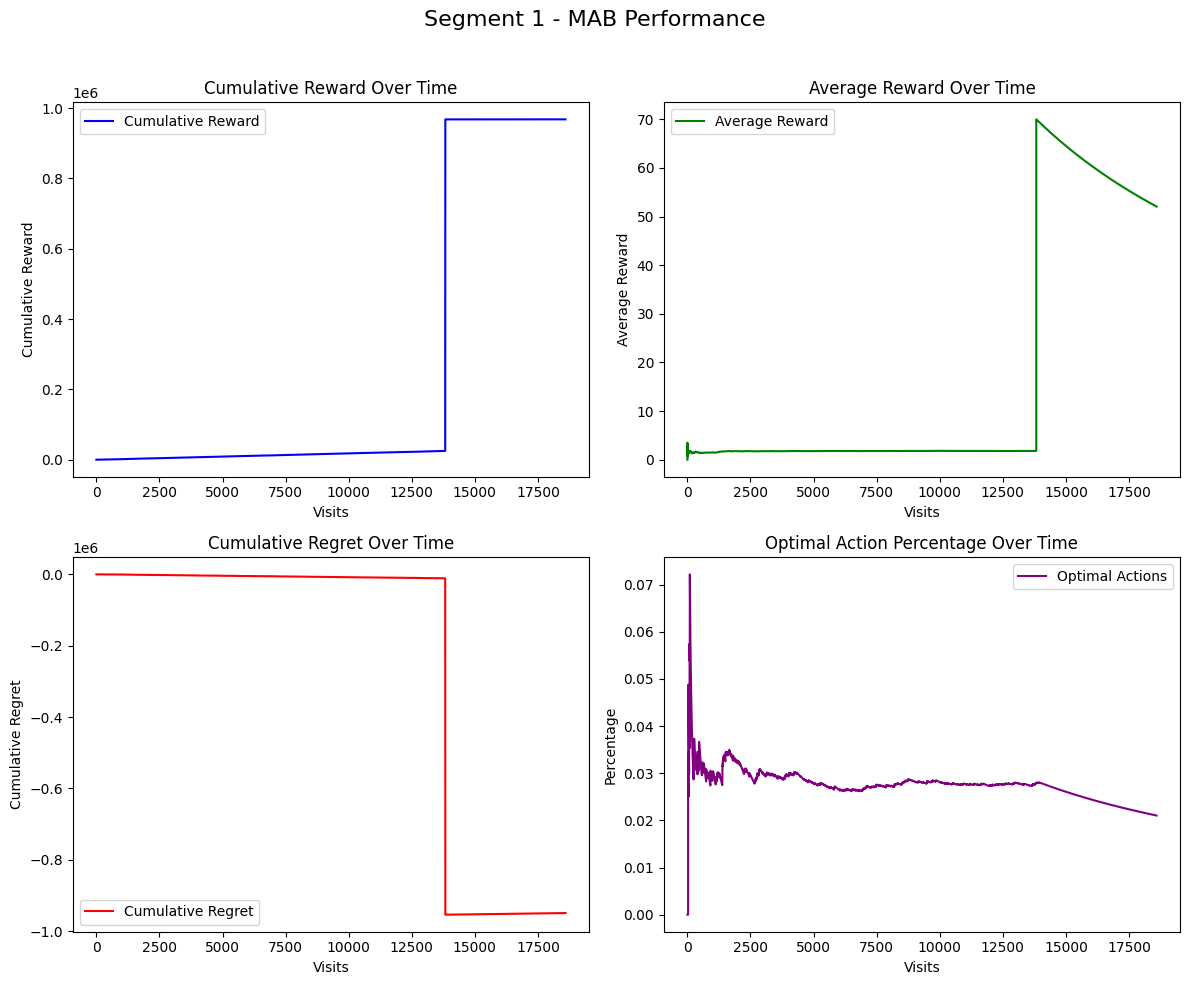

In [37]:
# Example usage
evaluate_mab_by_segment(segment_results_df)

In [38]:
from sklearn.metrics import roc_auc_score

In [39]:
# Hit Rate
def hit_rate_at_20(df):
    def user_hit(group):
        return int((group['rank'] <= 20).any())
    return df.groupby('user_id', group_keys=False).apply(user_hit, include_groups=False).mean()

# Precision
def precision_at_20(df):
    def user_precision(group):
        top_20 = group[group['rank'] <= 20]
        if len(top_20) == 0:
            return 0.0
        return top_20['reward'].sum() / len(top_20)
    return df.groupby('user_id', group_keys=False).apply(user_precision, include_groups=False).mean()

# Mean Reciprocal Rank (MRR)
def mean_reciprocal_rank(df):
    def user_mrr(group):
        sorted_group = group.sort_values('rank')
        relevant = sorted_group[sorted_group['reward'] > 0]
        if len(relevant) == 0:
            return 0.0
        return 1.0 / (relevant['rank'].iloc[0])
    return df.groupby('user_id', group_keys=False).apply(user_mrr, include_groups=False).mean()

# Normalized Discounted Cumulative Gain@20 (NDCG@20)
def ndcg_at_k(df, k=20):
    def dcg(rewards):
        return np.sum((2**rewards - 1) / np.log2(np.arange(2, len(rewards) + 2)))

    def user_ndcg(group):
        sorted_group = group.sort_values('rank').head(k)
        ideal_group = group.sort_values('reward', ascending=False).head(k)
        dcg_val = dcg(sorted_group['reward'].values)
        idcg_val = dcg(ideal_group['reward'].values)
        return dcg_val / idcg_val if idcg_val > 0 else 0.0
    return df.groupby('user_id', group_keys=False).apply(user_ndcg, include_groups=False).mean()

# AUC-ROC per user
def auc_roc(df):
    def user_auc(group):
        group = group[group['reward'].isin([0, 1])]
        if group['reward'].nunique() < 2:
            return np.nan
        scores = -group['rank'].fillna(9999)
        return roc_auc_score(group['reward'], scores)

    return df.groupby('user_id', group_keys=False).apply(user_auc, include_groups=False).mean()


In [40]:
def evaluate_all(df):
    hit = hit_rate_at_20(df)
    precision = precision_at_20(df)
    mrr = mean_reciprocal_rank(df)
    ndcg = ndcg_at_k(df)
    auc = auc_roc(df)

    print(f"Hit Rate@20: {hit:.4f}")
    print(f"Precision@20: {precision:.4f}")
    print(f"MRR: {mrr:.4f}")
    print(f"NDCG@20: {ndcg:.4f}")
    print(f"AUC-ROC: {auc:.4f}")

In [41]:
evaluate_all(segment_results_df)

Hit Rate@20: 1.0000
Precision@20: 56.7516
MRR: 0.6822
NDCG@20: 0.6672
AUC-ROC: 1.0000


In [43]:
segment_results_df.to_csv('/Users/ShanShan/BT4301/MySQL/test/cleaned/results2/ge/min20/ge_price/200000_visits_5_iterations/recommended_books_df.csv')